In [1]:
#IMPORTS
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib

Obtendo dados

In [2]:
df = pd.read_csv('../data/dados_limpos.csv')

In [3]:
df.head()

,appId,date,monthly_active_users,country,lang,predictionLoss,newinstalls,category,total_ratings,daily_ratings,reviews,daily_reviews,daily_active_users_TARGET
0,com.app.33540,2024-01-01,3643110.0,br,pt,8170.0,8068.0,FINANCE,223848.0,297.0,82172.0,46.0,393961.0
1,com.app.31679,2024-01-01,1349262.0,br,pt,4287.0,2160.0,FINANCE,277813.0,132.0,139907.0,19.0,157532.0
2,com.app.77385,2024-01-01,1934660.0,br,pt,4497.0,3136.0,FINANCE,197329.0,187.0,79637.0,25.0,239768.0
3,com.app.41189,2024-01-01,19039746.0,br,pt,45759.0,13830.0,FINANCE,3499378.0,766.0,952285.0,171.0,4954347.0
4,com.app.71740,2024-01-01,34421.0,br,pt,1463.0,100.0,FINANCE,8327.0,1.0,4351.0,1.0,2809.0


## Análise exploratória dos dados

### Analisando novamente a distribuição das variáveis numéricas

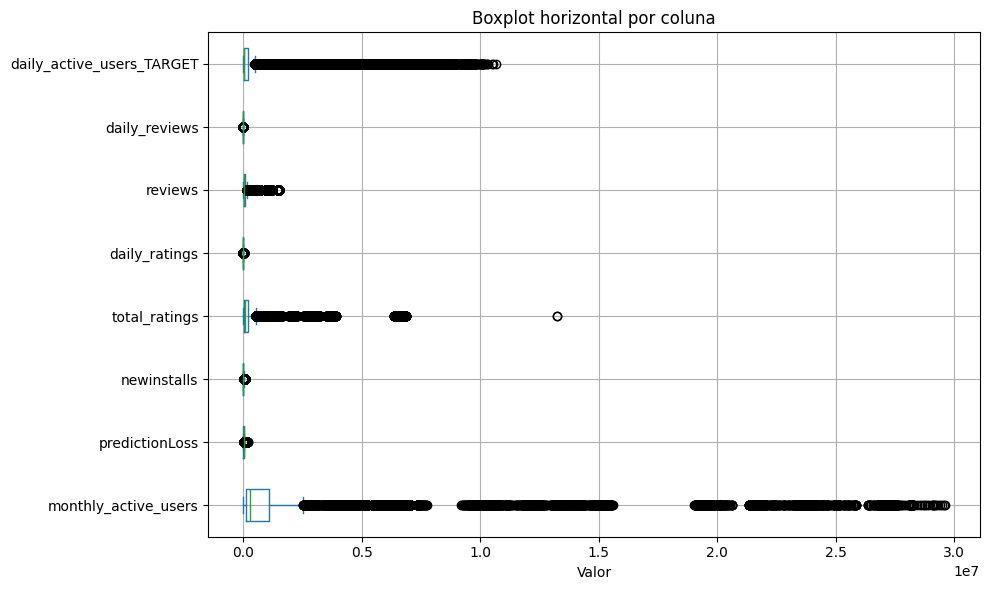

In [4]:
df.select_dtypes(include='number').plot(kind='box', vert=False, figsize=(10, 6))

plt.title("Boxplot horizontal por coluna")
plt.xlabel("Valor")
plt.grid(True)
plt.tight_layout()
plt.show()

Exceto total_ratings, não temos valores muito isolados

<Axes: >

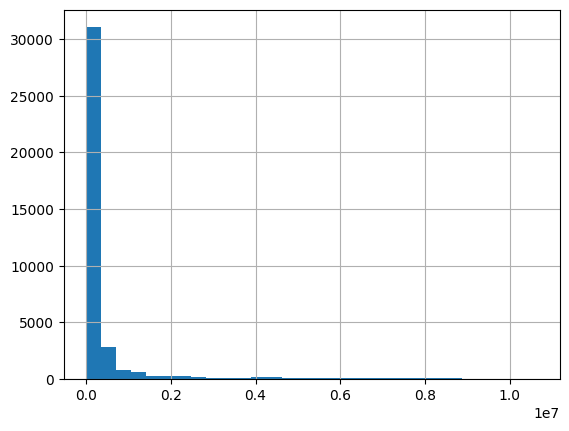

In [5]:
df['daily_active_users_TARGET'].hist(bins=30)

A variável alvo possui uma distribuição assimétrica. Pucos valores extremamente altos e muitos valores baixos.<br> 
- Para que o modelo possa aprender, ele precisa encontrar padrões nos dados e isso acontece de forma mais notória em dados onde as relações são mais lineares ou estáveis entre elas. É sempre mais dificil descobrir padrões em dados que não possuem nenhuma tendência de alta, de queda, de sazonalidade, etc. Uma das técnicas para ajudar o modelo neste caso é o uso do <b>np.log1p()</b>. Ele comprime os extremos e suaviza a variância, facilitando para o modelo aprender.

### Analisando séries ao longo do tempo por atributo de alguns Apps específicos

<Axes: title={'center': 'DAU médio por data'}, xlabel='date'>

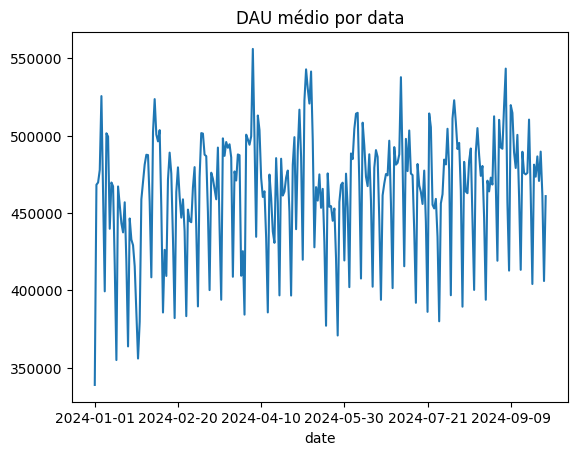

In [6]:
df.groupby('date')['daily_active_users_TARGET'].mean().plot(title='DAU médio por data')

Tendência crescente para a quantidade média de DAU para todos os apps.

Text(0.5, 1.0, 'DAU ao longo do tempo por App')

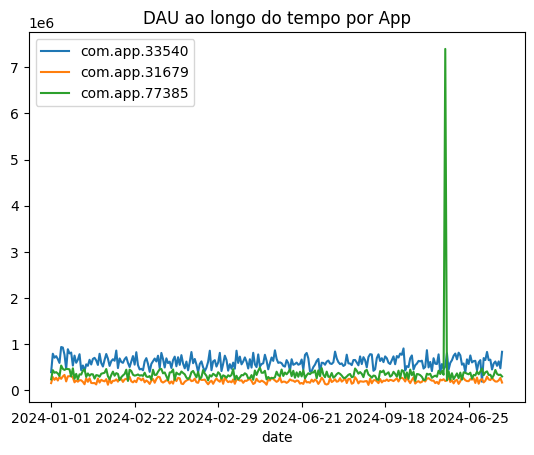

In [7]:
for app in df['appId'].unique()[:3]:  
    df[df['appId'] == app].set_index('date')['daily_active_users_TARGET'].plot(label=app)
plt.legend()
plt.title('DAU ao longo do tempo por App')

<Axes: xlabel='category', ylabel='daily_active_users_TARGET'>

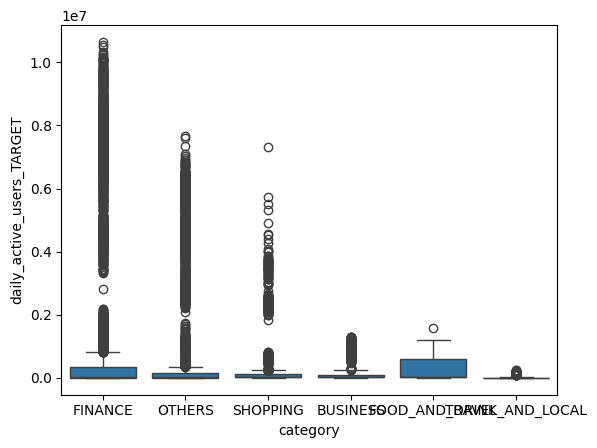

In [8]:
sns.boxplot(x='category', y='daily_active_users_TARGET', data=df)

<Axes: xlabel='dia_semana'>

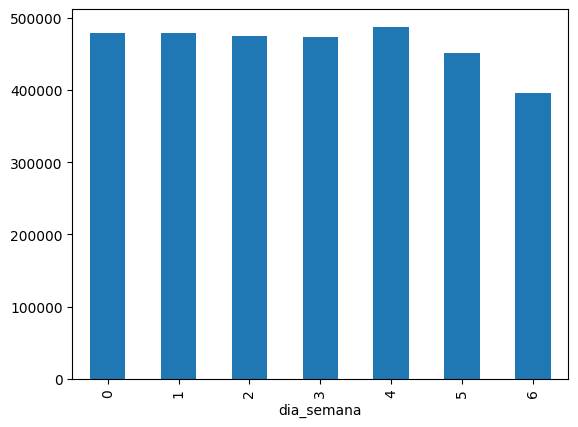

In [9]:
df['dia_semana'] = pd.to_datetime(df['date']).dt.dayofweek
df.groupby('dia_semana')['daily_active_users_TARGET'].mean().plot(kind='bar')

Pode ser um padrão a tentar mostrar para o modelo utilizando como variavel categorica

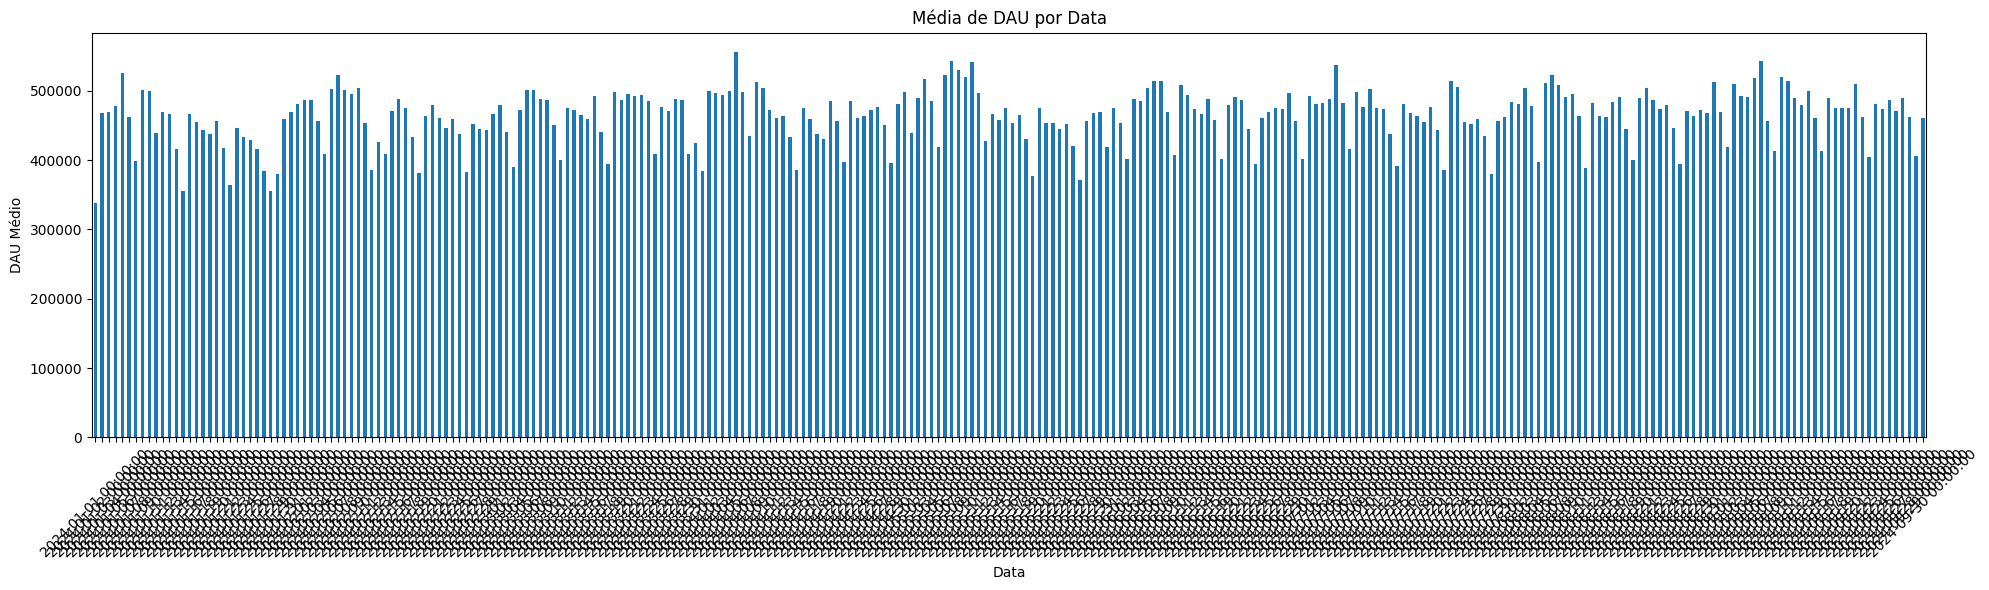

In [10]:
df['date'] = pd.to_datetime(df['date'])
media_por_data = df.groupby('date')['daily_active_users_TARGET'].mean()


plt.figure(figsize=(20, 6))  
media_por_data.plot(kind='bar')
plt.title('Média de DAU por Data')
plt.xlabel('Data')
plt.ylabel('DAU Médio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Aqui também podemos um movimento de leves altas e baixas a cada espaço de tempo. Podemos tentar entender qual é esse espaço para utilizar como variável também.

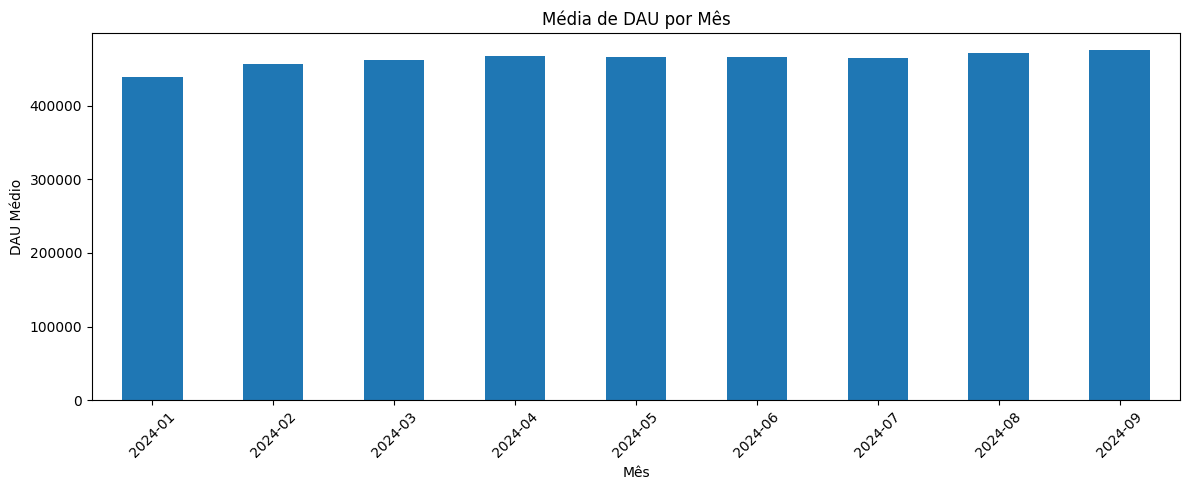

In [11]:
media_mensal = df.groupby(df['date'].dt.to_period('M'))['daily_active_users_TARGET'].mean()


media_mensal.index = media_mensal.index.astype(str)


plt.figure(figsize=(12, 5))
media_mensal.plot(kind='bar')
plt.title('Média de DAU por Mês')
plt.xlabel('Mês')
plt.ylabel('DAU Médio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

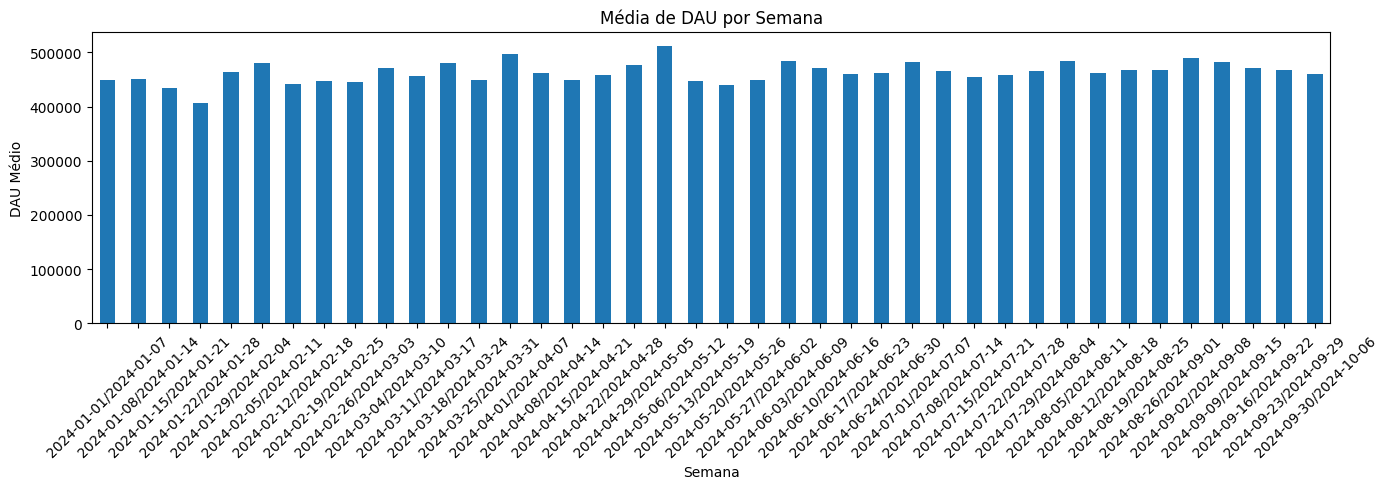

In [12]:
media_semanal = df.groupby(df['date'].dt.to_period('W'))['daily_active_users_TARGET'].mean()


media_semanal.index = media_semanal.index.astype(str)

# Plotar
plt.figure(figsize=(14, 5))
media_semanal.plot(kind='bar')
plt.title('Média de DAU por Semana')
plt.xlabel('Semana')
plt.ylabel('DAU Médio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\ACER\AppData\Local\Temp\ipykernel_13160\2253536259.py:56: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\tudo\Adenis\rankmyapp_case_senior_data_scientist\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


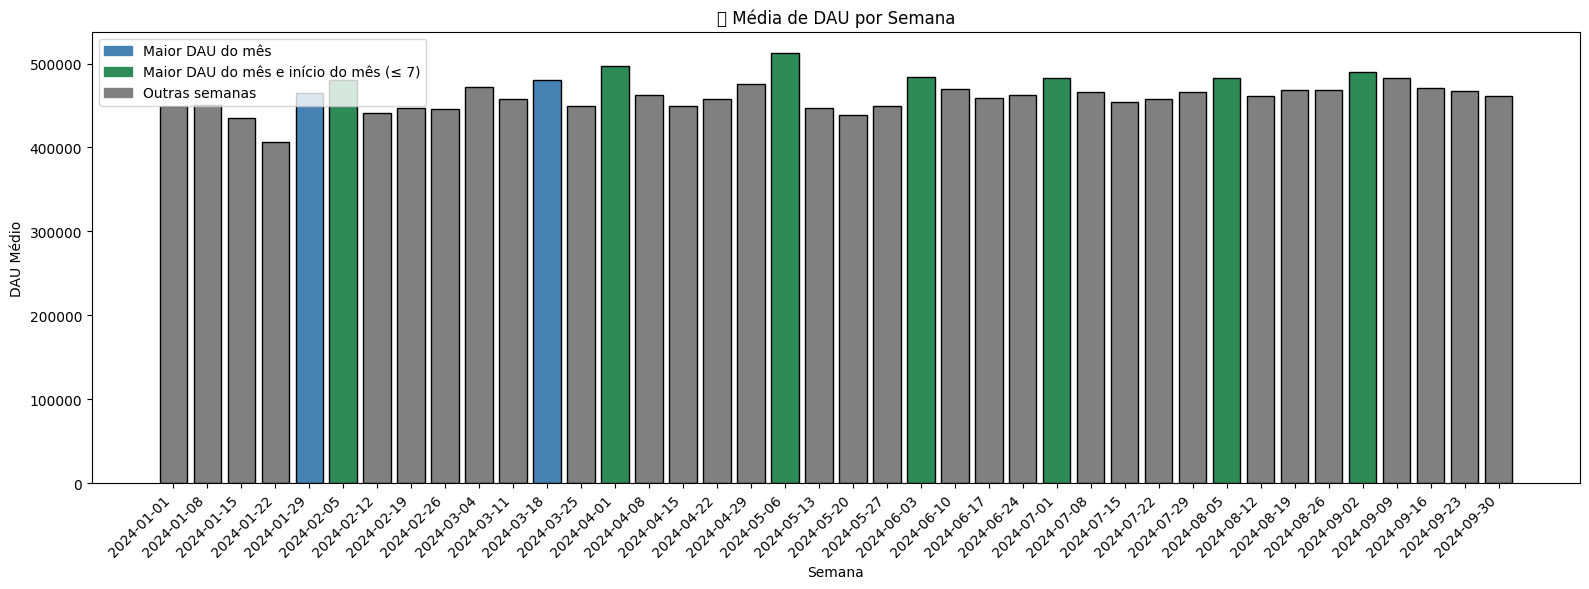

In [13]:
media_semanal = df.groupby(df['date'].dt.to_period('W'))['daily_active_users_TARGET'].mean()
media_semanal.index = media_semanal.index.to_timestamp()

# Criar DataFrame auxiliar
media_df = media_semanal.reset_index()
media_df['mes'] = media_df['date'].dt.to_period('M')
media_df['dia'] = media_df['date'].dt.day

# Identificar maior DAU de cada mês
idx_maiores = media_df.groupby('mes')['daily_active_users_TARGET'].idxmax()
media_df['maior_do_mes'] = False
media_df.loc[idx_maiores, 'maior_do_mes'] = True

# Identificar se semana começa nos primeiros 7 dias
media_df['inicio_mes'] = media_df['dia'] <= 7

# Definir cor base: cinza
media_df['cor'] = 'gray'

# Azul: maior do mês
media_df.loc[media_df['maior_do_mes'], 'cor'] = 'steelblue'

# Verde: maior do mês E início do mês
media_df.loc[media_df['maior_do_mes'] & media_df['inicio_mes'], 'cor'] = 'seagreen'

# Rótulos do eixo x
media_df['label'] = media_df['date'].dt.strftime('%Y-%m-%d')

# Plotar
plt.figure(figsize=(16, 6))
bars = plt.bar(
    x=range(len(media_df)),
    height=media_df['daily_active_users_TARGET'],
    color=media_df['cor'],
    edgecolor='black'
)

# Legenda com patches manuais
legend_patches = [
    mpatches.Patch(color='steelblue', label='Maior DAU do mês'),
    mpatches.Patch(color='seagreen', label='Maior DAU do mês e início do mês (≤ 7)'),
    mpatches.Patch(color='gray', label='Outras semanas')
]
plt.legend(handles=legend_patches)

# Eixos
plt.xticks(
    ticks=range(len(media_df)),
    labels=media_df['label'],
    rotation=45,
    ha='right'
)
plt.title('📊 Média de DAU por Semana')
plt.xlabel('Semana')
plt.ylabel('DAU Médio')
plt.tight_layout()
plt.show()

Aqui aparentemente temos um padrão de aumento de acessos no inicio do mes. Pode ser uma variável a mais para inserir no modelo

<Axes: xlabel='newinstalls', ylabel='daily_active_users_TARGET'>

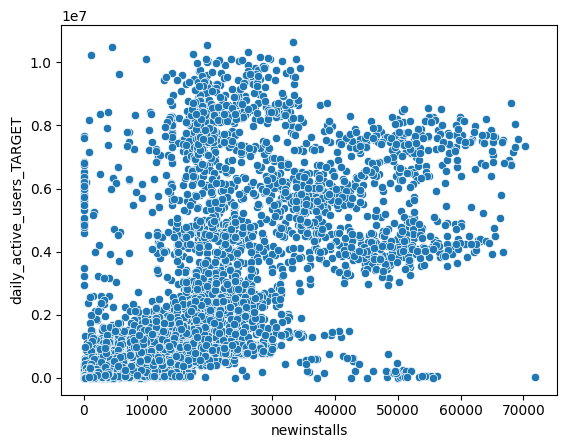

In [14]:
sns.scatterplot(x='newinstalls', y='daily_active_users_TARGET', data=df)

<Axes: xlabel='total_ratings', ylabel='daily_active_users_TARGET'>

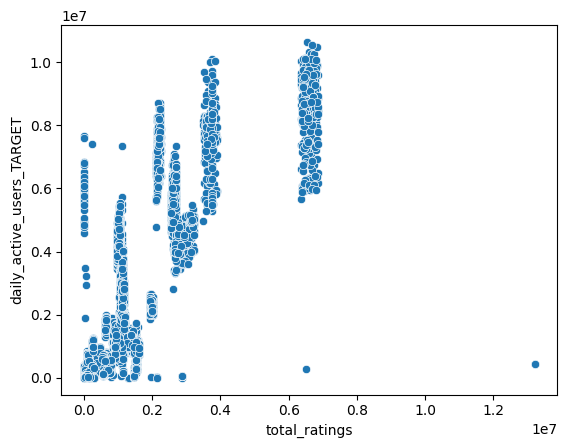

In [15]:
sns.scatterplot(x='total_ratings', y='daily_active_users_TARGET', data=df)

<Axes: xlabel='daily_ratings', ylabel='daily_active_users_TARGET'>

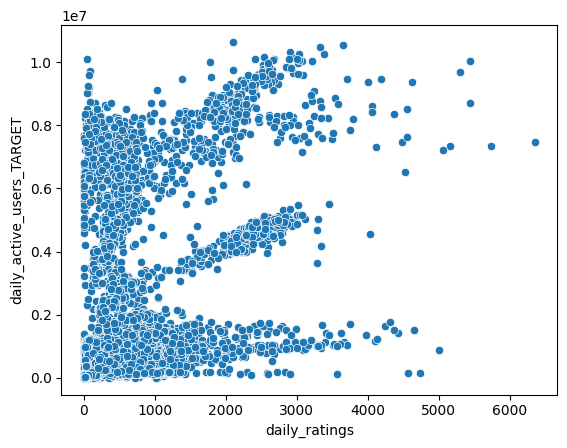

In [16]:
sns.scatterplot(x='daily_ratings', y='daily_active_users_TARGET', data=df)

<Axes: xlabel='reviews', ylabel='daily_active_users_TARGET'>

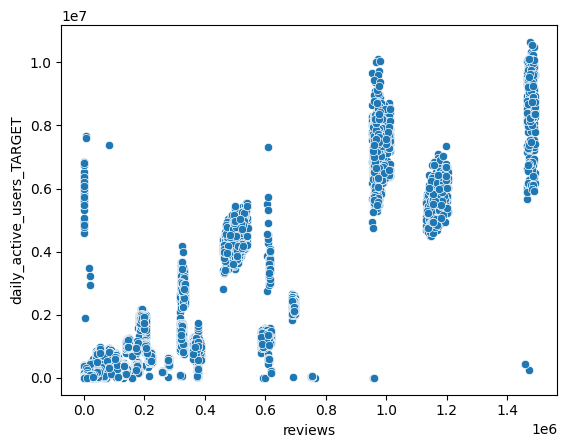

In [17]:
sns.scatterplot(x='reviews', y='daily_active_users_TARGET', data=df)

Aqui é possível encontrar uma correlação positiva (total de reviews e usuários ativos por dia)

<Axes: xlabel='daily_reviews', ylabel='daily_active_users_TARGET'>

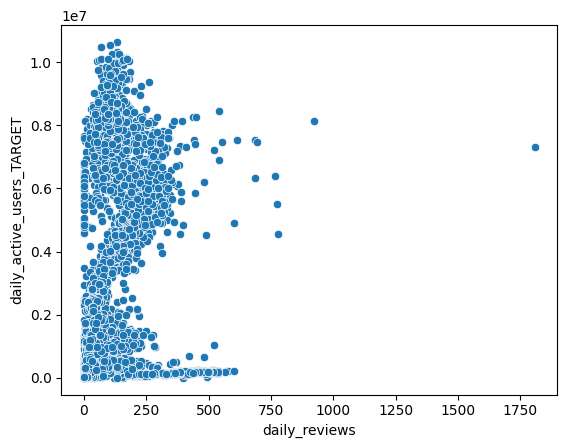

In [18]:
sns.scatterplot(x='daily_reviews', y='daily_active_users_TARGET', data=df)

In [19]:
def gera_grafico_linhas(app_id, atributo):
    df_filtrado = df[df['appId'] == app_id]
    df_agrupado = df_filtrado.groupby('date')[atributo].sum().reset_index()
    plt.figure(figsize=(10, 5))
    plt.plot(df_agrupado['date'], df_agrupado[atributo], marker='o')
    plt.title(f'Quantidade de {atributo} ao longo do tempo')
    plt.xlabel('Data')
    plt.ylabel('Quantidade')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

MONTHLY_ACTIVE_USERS

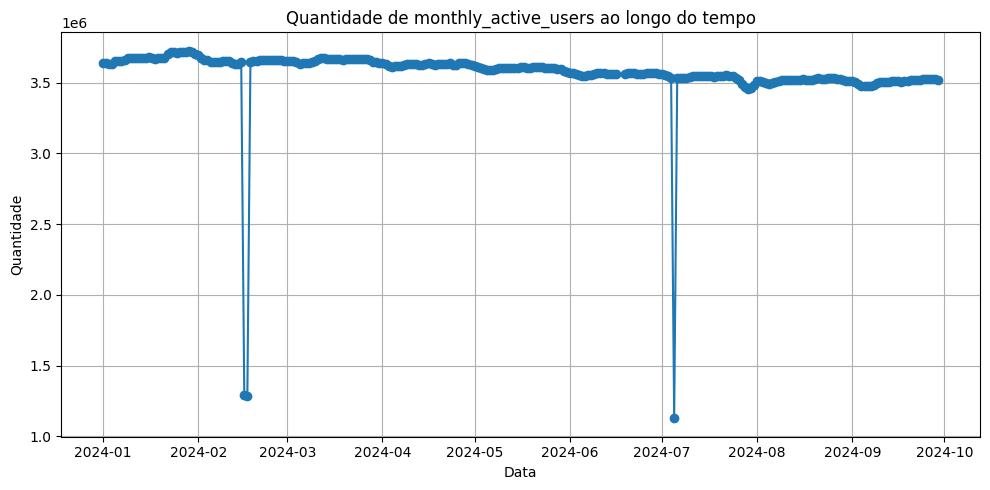

In [20]:
gera_grafico_linhas('com.app.33540', 'monthly_active_users')

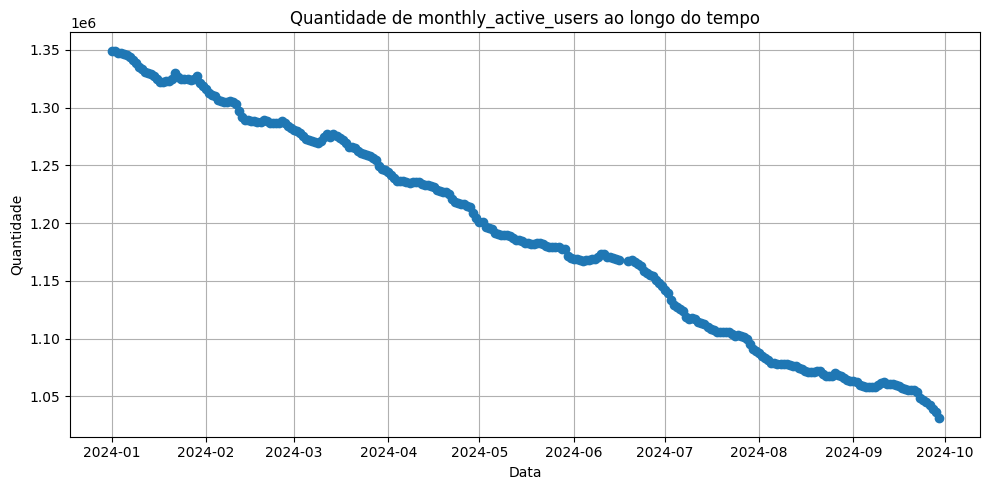

In [21]:
gera_grafico_linhas('com.app.31679', 'monthly_active_users')

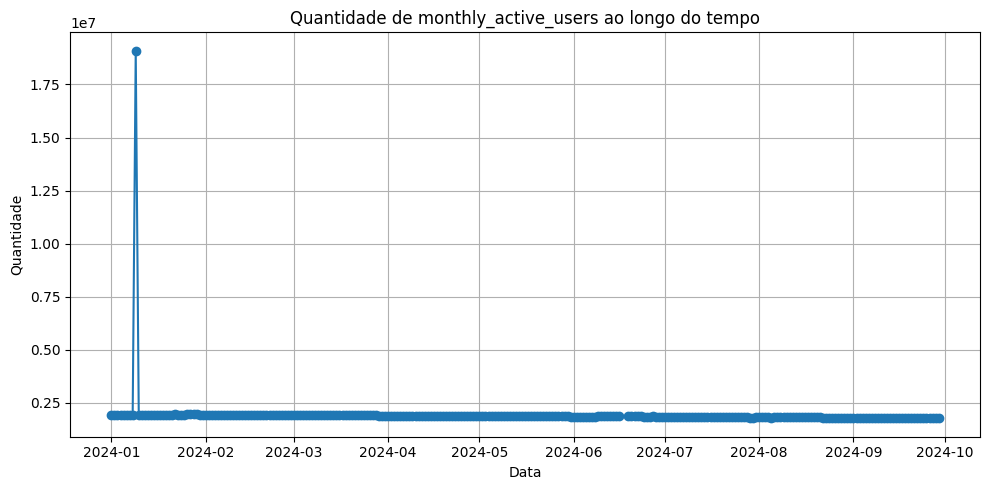

In [22]:
gera_grafico_linhas('com.app.77385', 'monthly_active_users')

Para a variável monthly_active_users é possível perceber que as séries são bem diferentes entre cada aplicativo

DAILY REVIEWS

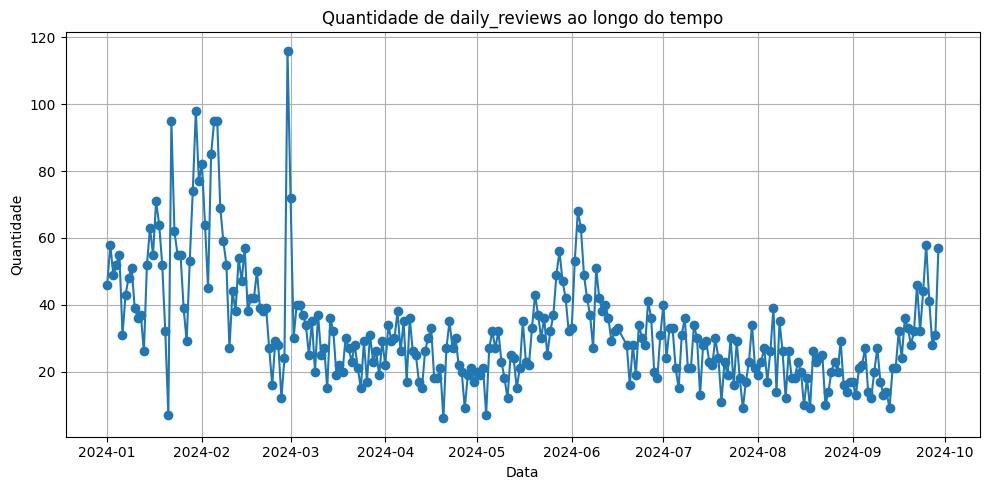

In [23]:
gera_grafico_linhas('com.app.33540', 'daily_reviews')

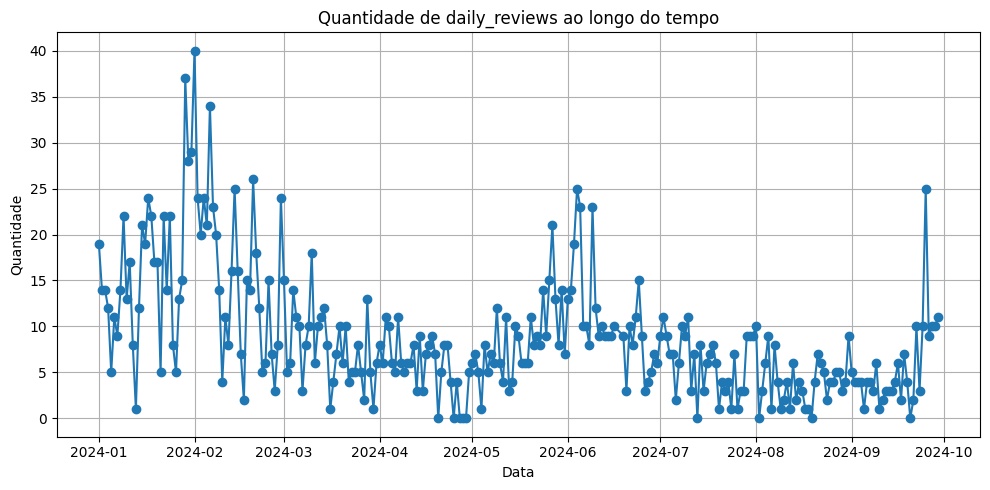

In [24]:
gera_grafico_linhas('com.app.31679', 'daily_reviews')

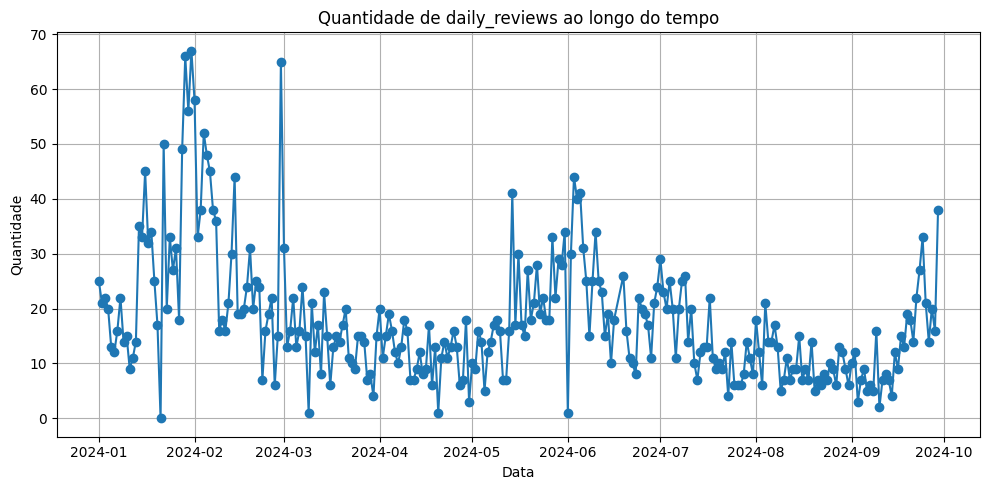

In [25]:
gera_grafico_linhas('com.app.77385', 'daily_reviews')

Já para a variável daily_reviews existe um padrão ao longo do tempo (pelo menos em 3 apps analisados). Seria por alguma campanha?

NEWINSTALLS

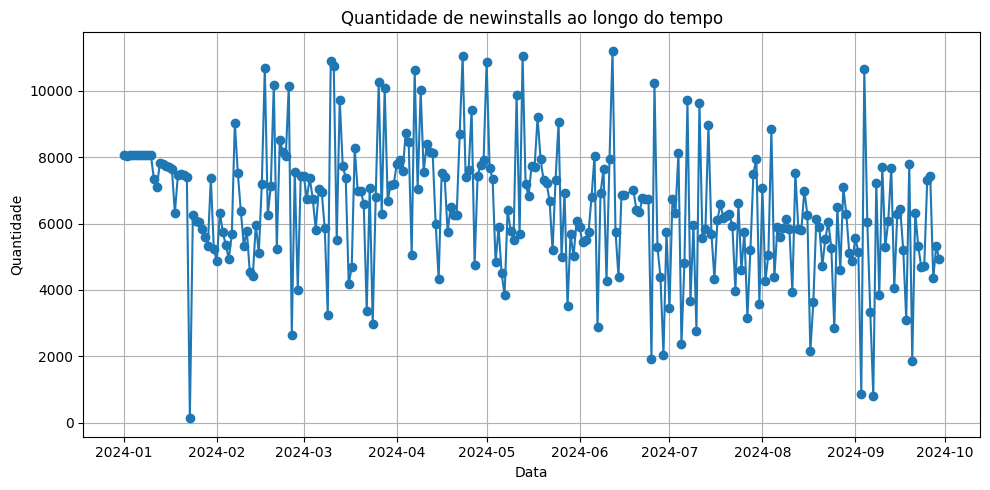

In [26]:
gera_grafico_linhas('com.app.33540', 'newinstalls')

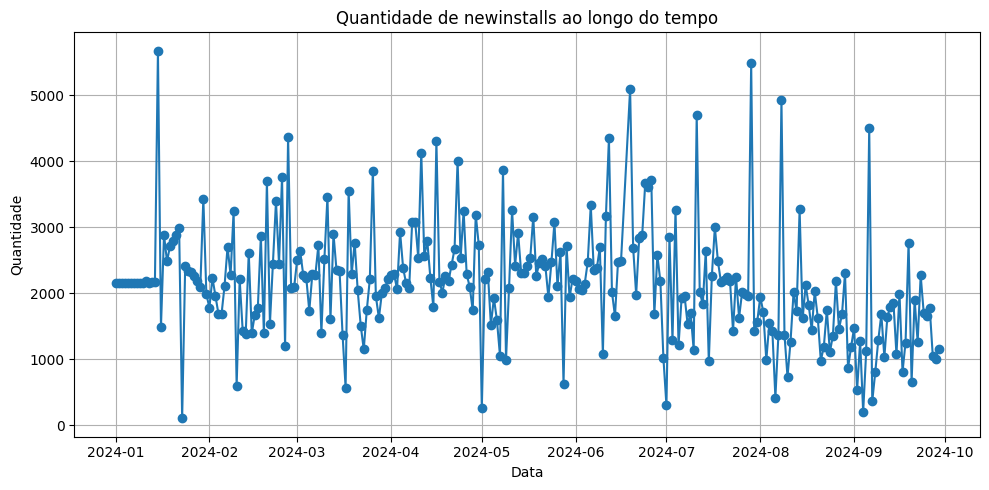

In [27]:
gera_grafico_linhas('com.app.31679', 'newinstalls')

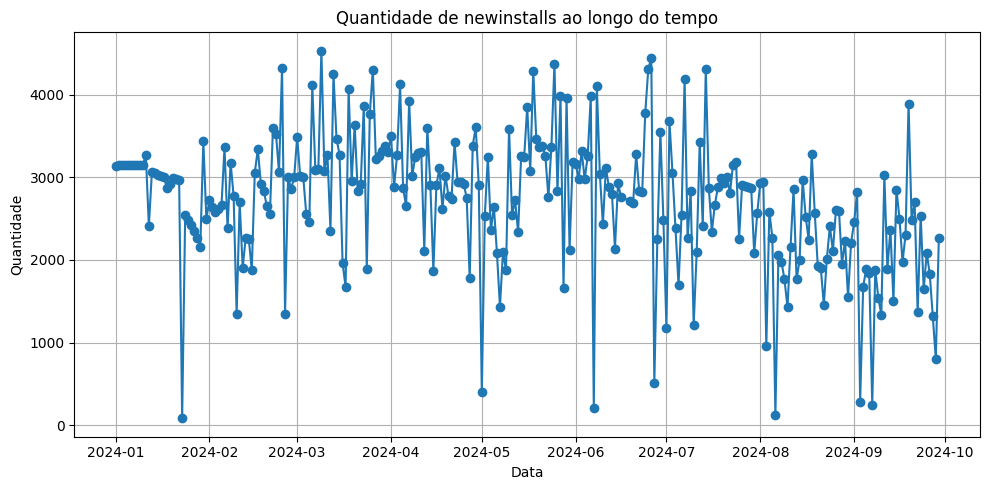

In [28]:
gera_grafico_linhas('com.app.77385', 'newinstalls')

A variável newinstalls se comporta de forma semelhante entre os aplicativos ao longo do tempo

## Feature Engeneering

In [29]:
df.head(10)

,appId,date,monthly_active_users,country,lang,predictionLoss,newinstalls,category,total_ratings,daily_ratings,reviews,daily_reviews,daily_active_users_TARGET,dia_semana
0,com.app.33540,2024-01-01,3643110.0,br,pt,8170.0,8068.0,FINANCE,223848.0,297.0,82172.0,46.0,393961.0,0
1,com.app.31679,2024-01-01,1349262.0,br,pt,4287.0,2160.0,FINANCE,277813.0,132.0,139907.0,19.0,157532.0,0
2,com.app.77385,2024-01-01,1934660.0,br,pt,4497.0,3136.0,FINANCE,197329.0,187.0,79637.0,25.0,239768.0,0
3,com.app.41189,2024-01-01,19039746.0,br,pt,45759.0,13830.0,FINANCE,3499378.0,766.0,952285.0,171.0,4954347.0,0
4,com.app.71740,2024-01-01,34421.0,br,pt,1463.0,100.0,FINANCE,8327.0,1.0,4351.0,1.0,2809.0,0
5,com.app.19772,2024-01-01,892322.0,br,pt,5986.0,1125.0,FINANCE,180081.0,30.0,56227.0,10.0,155132.0,0
6,com.app.31153,2024-01-01,5876215.0,br,pt,45584.0,24587.0,FINANCE,1036500.0,381.0,182229.0,86.0,1337381.0,0
7,com.app.82896,2024-01-01,184014.0,br,pt,3006.0,1218.0,FINANCE,15353.0,20.0,3296.0,18.0,9976.0,0
8,com.app.36648,2024-01-01,684357.0,br,pt,1546.0,415.0,FINANCE,145442.0,26.0,46032.0,4.0,184528.0,0
9,com.app.62109,2024-01-01,7033633.0,br,pt,16793.0,10128.0,FINANCE,810247.0,622.0,316558.0,73.0,847493.0,0


In [30]:
df = df.sort_values(['appId', 'date'])

#gerar variáveis de janela de tempo para cada atributo que temos na base
#predictionLoss
df['predictionLoss_ultimos_3_dias'] = (df.groupby('appId')['predictionLoss'].rolling(window=3, min_periods=1).sum().reset_index(level=0, drop=True))
df['predictionLoss_ultimos_7_dias'] = (df.groupby('appId')['predictionLoss'].rolling(window=7, min_periods=1).sum().reset_index(level=0, drop=True))
df['predictionLoss_ultimos_15_dias'] = (df.groupby('appId')['predictionLoss'].rolling(window=15, min_periods=1).sum().reset_index(level=0, drop=True))
df['predictionLoss_ultimos_30_dias'] = (df.groupby('appId')['predictionLoss'].rolling(window=30, min_periods=1).sum().reset_index(level=0, drop=True))


#newinstalls
df['newinstalls_ultimos_3_dias'] = (df.groupby('appId')['newinstalls'].rolling(window=3, min_periods=1).sum().reset_index(level=0, drop=True))
df['newinstalls_ultimos_7_dias'] = (df.groupby('appId')['newinstalls'].rolling(window=7, min_periods=1).sum().reset_index(level=0, drop=True))
df['newinstalls_ultimos_15_dias'] = (df.groupby('appId')['newinstalls'].rolling(window=15, min_periods=1).sum().reset_index(level=0, drop=True))
df['newinstalls_ultimos_30_dias'] = (df.groupby('appId')['newinstalls'].rolling(window=30, min_periods=1).sum().reset_index(level=0, drop=True))


#total_ratings
df['total_ratings_ultimos_3_dias'] = (df.groupby('appId')['total_ratings'].rolling(window=3, min_periods=1).sum().reset_index(level=0, drop=True))
df['total_ratings_ultimos_7_dias'] = (df.groupby('appId')['total_ratings'].rolling(window=7, min_periods=1).sum().reset_index(level=0, drop=True))
df['total_ratings_ultimos_15_dias'] = (df.groupby('appId')['total_ratings'].rolling(window=15, min_periods=1).sum().reset_index(level=0, drop=True))
df['total_ratings_ultimos_30_dias'] = (df.groupby('appId')['total_ratings'].rolling(window=30, min_periods=1).sum().reset_index(level=0, drop=True))


#daily_ratings
df['daily_ratings_ultimos_3_dias'] = (df.groupby('appId')['daily_ratings'].rolling(window=3, min_periods=1).sum().reset_index(level=0, drop=True))
df['daily_ratings_ultimos_7_dias'] = (df.groupby('appId')['daily_ratings'].rolling(window=7, min_periods=1).sum().reset_index(level=0, drop=True))
df['daily_ratings_ultimos_15_dias'] = (df.groupby('appId')['daily_ratings'].rolling(window=15, min_periods=1).sum().reset_index(level=0, drop=True))
df['daily_ratings_ultimos_30_dias'] = (df.groupby('appId')['daily_ratings'].rolling(window=30, min_periods=1).sum().reset_index(level=0, drop=True))


#reviews
df['reviews_ultimos_3_dias'] = (df.groupby('appId')['reviews'].rolling(window=3, min_periods=1).sum().reset_index(level=0, drop=True))
df['reviews_ultimos_7_dias'] = (df.groupby('appId')['reviews'].rolling(window=7, min_periods=1).sum().reset_index(level=0, drop=True))
df['reviews_ultimos_15_dias'] = (df.groupby('appId')['reviews'].rolling(window=15, min_periods=1).sum().reset_index(level=0, drop=True))
df['reviews_ultimos_30_dias'] = (df.groupby('appId')['reviews'].rolling(window=30, min_periods=1).sum().reset_index(level=0, drop=True))


#daily_reviews
df['daily_reviews_ultimos_3_dias'] = (df.groupby('appId')['daily_reviews'].rolling(window=3, min_periods=1).sum().reset_index(level=0, drop=True))
df['daily_reviews_ultimos_7_dias'] = (df.groupby('appId')['daily_reviews'].rolling(window=7, min_periods=1).sum().reset_index(level=0, drop=True))
df['daily_reviews_ultimos_15_dias'] = (df.groupby('appId')['daily_reviews'].rolling(window=15, min_periods=1).sum().reset_index(level=0, drop=True))
df['daily_reviews_ultimos_30_dias'] = (df.groupby('appId')['daily_reviews'].rolling(window=30, min_periods=1).sum().reset_index(level=0, drop=True))


#daily_active_users_TARGET
df['daily_active_users_ultimos_3_dias'] = (df.groupby('appId')['daily_active_users_TARGET'].rolling(window=3, min_periods=1).sum().reset_index(level=0, drop=True))
df['daily_active_users_ultimos_7_dias'] = (df.groupby('appId')['daily_active_users_TARGET'].rolling(window=7, min_periods=1).sum().reset_index(level=0, drop=True))
df['daily_active_users_ultimos_15_dias'] = (df.groupby('appId')['daily_active_users_TARGET'].rolling(window=15, min_periods=1).sum().reset_index(level=0, drop=True))
df['daily_active_users_ultimos_30_dias'] = (df.groupby('appId')['daily_active_users_TARGET'].rolling(window=30, min_periods=1).sum().reset_index(level=0, drop=True))


#criação de delta_ratings, delta_reviews e variável de fim de semana
df['delta_ratings'] = df['daily_ratings'] / df['total_ratings']
df['delta_reviews'] = df['daily_reviews'] / df['reviews']
df['fim_de_semana'] = df['dia_semana'].isin([5, 6])
df['inicio_do_mes'] = df['date'].dt.day <= 7

In [31]:
df.head(10)

,appId,date,monthly_active_users,country,lang,predictionLoss,newinstalls,category,total_ratings,daily_ratings,...,daily_reviews_ultimos_15_dias,daily_reviews_ultimos_30_dias,daily_active_users_ultimos_3_dias,daily_active_users_ultimos_7_dias,daily_active_users_ultimos_15_dias,daily_active_users_ultimos_30_dias,delta_ratings,delta_reviews,fim_de_semana,inicio_do_mes
2934,com.app.10626,2024-03-23,1950503.0,br,pt,34696.0,4003.0,FINANCE,459577.0,560.0,...,84.0,84.0,223700.0,223700.0,223700.0,223700.0,0.001219,0.000705,True,False
21948,com.app.10626,2024-03-24,1955504.0,br,pt,34103.0,4016.0,FINANCE,460137.0,462.0,...,186.0,186.0,430684.0,430684.0,430684.0,430684.0,0.001004,0.000855,True,False
16936,com.app.10626,2024-03-25,1953859.0,br,pt,35773.0,4026.0,FINANCE,460599.0,586.0,...,309.0,309.0,695329.0,695329.0,695329.0,695329.0,0.001272,0.001030,False,False
32107,com.app.10626,2024-03-26,1950521.0,br,pt,35634.0,4028.0,FINANCE,461185.0,633.0,...,413.0,413.0,731235.0,954935.0,954935.0,954935.0,0.001373,0.000870,False,False
35591,com.app.10626,2024-03-27,1944722.0,br,pt,36066.0,4023.0,FINANCE,461818.0,504.0,...,508.0,508.0,771709.0,1202393.0,1202393.0,1202393.0,0.001091,0.000794,False,False
15120,com.app.10626,2024-03-28,1943102.0,br,pt,35376.0,4007.0,FINANCE,462322.0,532.0,...,640.0,640.0,794648.0,1489977.0,1489977.0,1489977.0,0.001151,0.001103,False,False
17312,com.app.10626,2024-03-29,1936818.0,br,pt,37580.0,4013.0,FINANCE,462854.0,649.0,...,745.0,745.0,810128.0,1765063.0,1765063.0,1765063.0,0.001402,0.000876,False,False
19904,com.app.10626,2024-03-30,1934415.0,br,pt,34888.0,4017.0,FINANCE,463503.0,515.0,...,822.0,822.0,799256.0,1777949.0,2001649.0,2001649.0,0.001111,0.000642,True,False
18591,com.app.10626,2024-03-31,1930107.0,br,pt,34257.0,4019.0,FINANCE,464018.0,370.0,...,940.0,940.0,707305.0,1766598.0,2197282.0,2197282.0,0.000797,0.000983,True,False
19326,com.app.10626,2024-04-01,1928243.0,br,pt,37815.0,4019.0,FINANCE,464388.0,553.0,...,1049.0,1049.0,730728.0,1800462.0,2495791.0,2495791.0,0.001191,0.000907,False,True


In [32]:
df.corr(numeric_only=True)['daily_active_users_TARGET'].sort_values(ascending=False)

daily_active_users_TARGET             1.000000
daily_active_users_ultimos_3_dias     0.992905
daily_active_users_ultimos_7_dias     0.987150
daily_active_users_ultimos_15_dias    0.979636
daily_active_users_ultimos_30_dias    0.969066
reviews_ultimos_3_dias                0.909529
reviews                               0.909109
reviews_ultimos_7_dias                0.907269
monthly_active_users                  0.903678
reviews_ultimos_15_dias               0.902536
reviews_ultimos_30_dias               0.894608
total_ratings_ultimos_3_dias          0.877057
total_ratings_ultimos_7_dias          0.876089
total_ratings                         0.872791
total_ratings_ultimos_15_dias         0.871736
total_ratings_ultimos_30_dias         0.863671
newinstalls_ultimos_15_dias           0.788257
newinstalls_ultimos_7_dias            0.787962
newinstalls_ultimos_30_dias           0.784945
newinstalls_ultimos_3_dias            0.784901
newinstalls                           0.766206
predictionLos

De acordo com os indices de correlação acima, existe a possibilidade de Data Leakage para as variáveis <br>
- daily_active_users_ultimos_3_dias: 0.992905 <br>
- daily_active_users_ultimos_7_dias: 0.987150 <br>
- daily_active_users_ultimos_15_dias: 0.979636 <br>
- daily_active_users_ultimos_30_dias: 0.969066 <br><br>

Essas variáveis podem ser redundantes para o modelo.

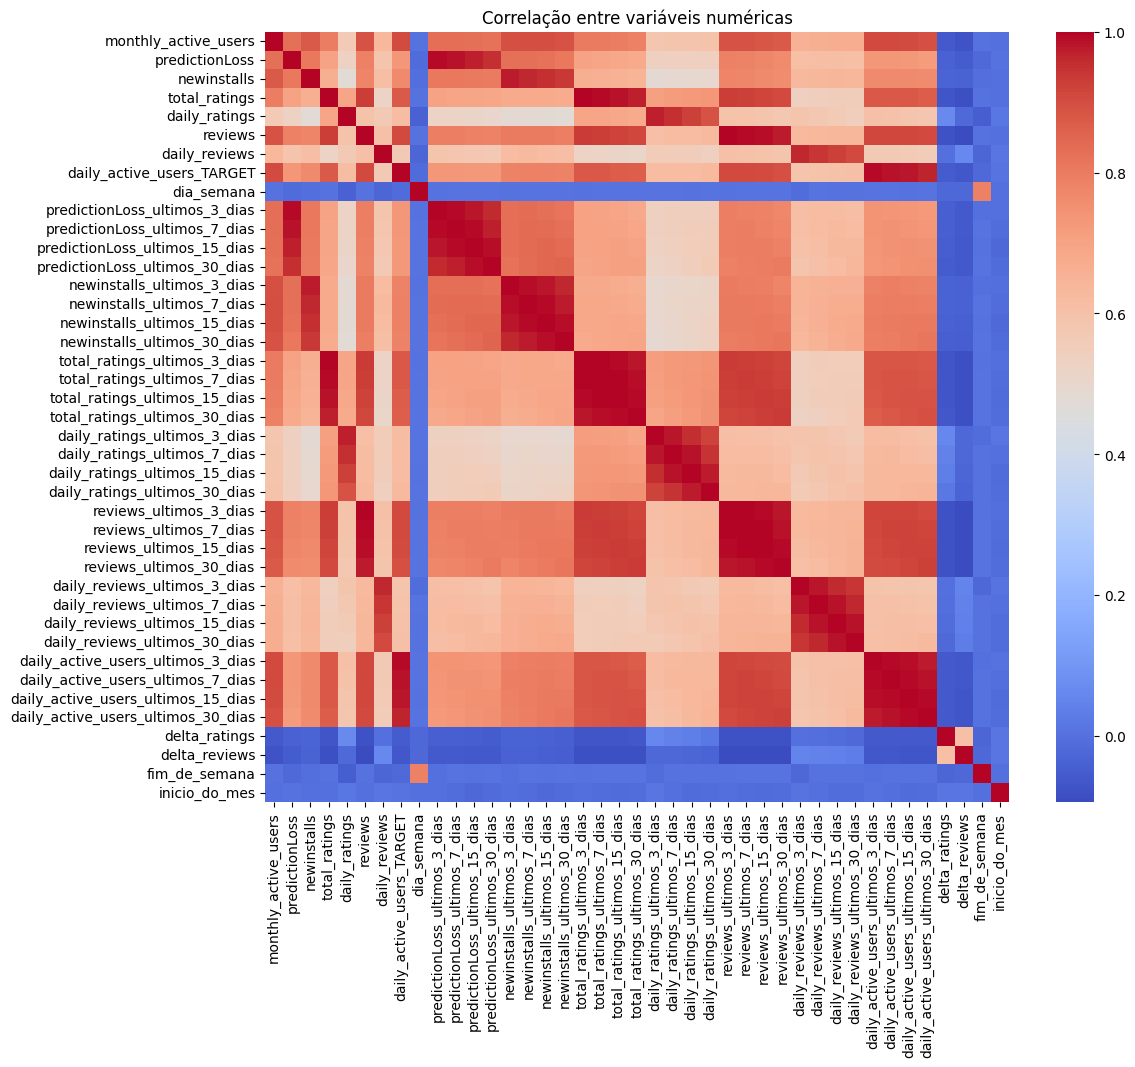

In [33]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title('Correlação entre variáveis numéricas')
plt.show()

Aqui é possível perceber que as variáveis criadas anteriormente de 3, 7, 15 e 30 dias possuem alta correlação com as variáveis utilizadas para criá-las. Pode ser interessante remover, para que não haja redundância do modelo. As variaveis delta tambem possuem correlação muito baixa com a variável alvo.

### Tratando Data Leakage, redundâncias e colinearidade

As variáveis abaixo foram construídas com base na variável alvo, então certamente terão data leakage. Ou seja, essas variáveis já praticamente trazem a resposta para o modelo.

In [34]:
df.drop(columns=['daily_active_users_ultimos_3_dias', 'daily_active_users_ultimos_7_dias', 'daily_active_users_ultimos_15_dias', 'daily_active_users_ultimos_30_dias'], inplace=True)

As variáveis abaixo apresentam alta colinearidade, portanto, vamos manter apenas as originais e a janela de tempo dos últimos 30 dias

In [35]:
df.drop(columns=['predictionLoss_ultimos_3_dias', 'predictionLoss_ultimos_7_dias', 'predictionLoss_ultimos_15_dias', 'newinstalls_ultimos_3_dias',
                 'newinstalls_ultimos_7_dias', 'newinstalls_ultimos_15_dias', 'total_ratings_ultimos_3_dias', 'total_ratings_ultimos_7_dias',
                 'total_ratings_ultimos_15_dias', 'daily_ratings_ultimos_3_dias', 'daily_ratings_ultimos_7_dias', 'daily_ratings_ultimos_15_dias',
                 'reviews_ultimos_3_dias', 'reviews_ultimos_7_dias', 'reviews_ultimos_15_dias', 'daily_reviews_ultimos_3_dias', 'daily_reviews_ultimos_7_dias',
                 'daily_reviews_ultimos_15_dias'], inplace=True)

### Verificando feature importances

C:\Users\ACER\AppData\Local\Temp\ipykernel_13160\2213597233.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(20), y=importances.head(20).index, palette='viridis')


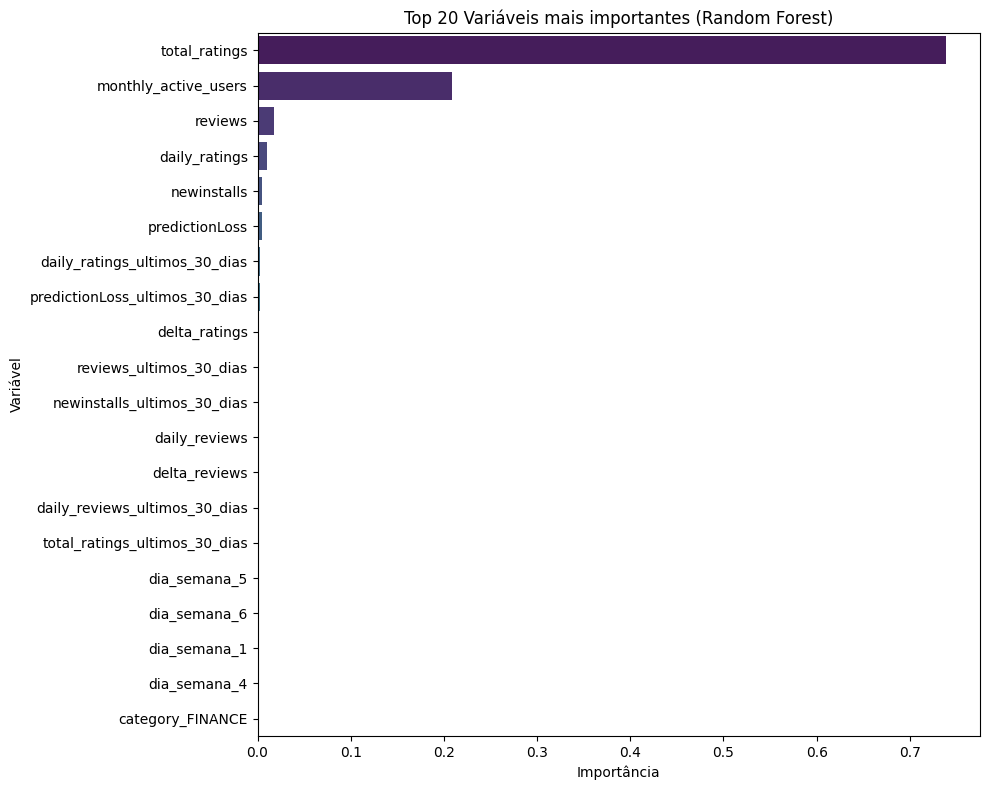

In [36]:
df['dia_semana'] = df['dia_semana'].astype(str)
y = df['daily_active_users_TARGET']

df_model = df.drop(columns=['daily_active_users_TARGET', 'appId', 'date'])
colunas_numericas = df_model.select_dtypes(include=np.number).columns
colunas_categoricas = df_model.select_dtypes(include=['object', 'category']).columns
df_dummies = pd.get_dummies(df_model[colunas_categoricas], drop_first=True)

scaler = StandardScaler()
df_numericas = pd.DataFrame(scaler.fit_transform(df_model[colunas_numericas]), columns=colunas_numericas)
X = pd.concat([df_numericas, df_dummies], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #manter temporalidade com shuffle=False

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)


plt.figure(figsize=(10, 8))
sns.barplot(x=importances.head(20), y=importances.head(20).index, palette='viridis')
plt.title("Top 20 Variáveis mais importantes (Random Forest)")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

In [37]:
importances

total_ratings                     0.738405
monthly_active_users              0.208208
reviews                           0.017877
daily_ratings                     0.010643
newinstalls                       0.005196
predictionLoss                    0.004551
daily_ratings_ultimos_30_dias     0.002320
predictionLoss_ultimos_30_dias    0.002286
delta_ratings                     0.002107
reviews_ultimos_30_dias           0.002005
newinstalls_ultimos_30_dias       0.001540
daily_reviews                     0.001266
delta_reviews                     0.001101
daily_reviews_ultimos_30_dias     0.000984
total_ratings_ultimos_30_dias     0.000842
dia_semana_5                      0.000100
dia_semana_6                      0.000083
dia_semana_1                      0.000078
dia_semana_4                      0.000068
category_FINANCE                  0.000062
category_SHOPPING                 0.000062
dia_semana_2                      0.000058
category_OTHERS                   0.000049
dia_semana_

Verificando as Feature Importances com a variável "inicio_de_semana"

C:\Users\ACER\AppData\Local\Temp\ipykernel_13160\764607383.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(20), y=importances.head(20).index, palette='viridis')


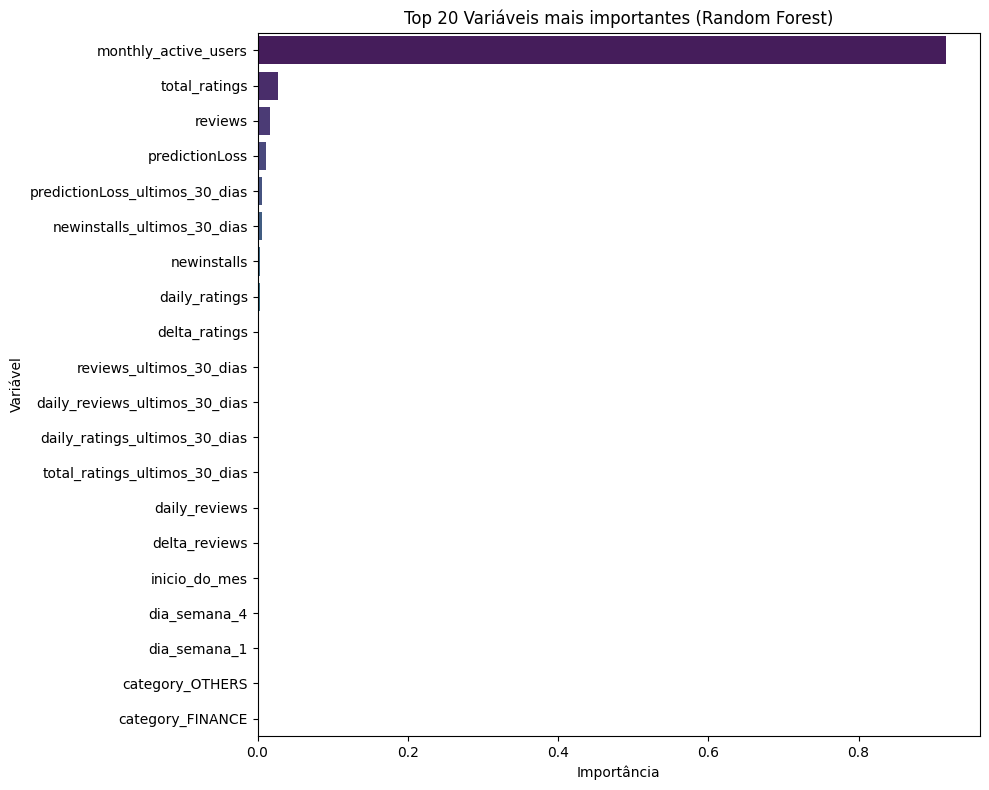

In [38]:
df['dia_semana'] = df['dia_semana'].astype(str)
y = np.log1p(df['daily_active_users_TARGET'])


df_model = df.drop(columns=['daily_active_users_TARGET', 'appId', 'date'])
colunas_numericas = df_model.select_dtypes(include=np.number).columns
colunas_categoricas = df_model.select_dtypes(include=['object', 'category', 'bool']).columns
df_dummies = pd.get_dummies(df_model[colunas_categoricas], drop_first=True)


scaler = StandardScaler()
df_numericas = pd.DataFrame(scaler.fit_transform(df_model[colunas_numericas]), columns=colunas_numericas)


X = pd.concat([df_numericas, df_dummies], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)


plt.figure(figsize=(10, 8))
sns.barplot(x=importances.head(20), y=importances.head(20).index, palette='viridis')
plt.title("Top 20 Variáveis mais importantes (Random Forest)")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

In [39]:
importances

monthly_active_users              0.915891
total_ratings                     0.027661
reviews                           0.016071
predictionLoss                    0.010697
predictionLoss_ultimos_30_dias    0.005866
newinstalls_ultimos_30_dias       0.005604
newinstalls                       0.003263
daily_ratings                     0.002880
delta_ratings                     0.002235
reviews_ultimos_30_dias           0.002110
daily_reviews_ultimos_30_dias     0.002029
daily_ratings_ultimos_30_dias     0.001742
total_ratings_ultimos_30_dias     0.001697
daily_reviews                     0.000861
delta_reviews                     0.000694
inicio_do_mes                     0.000077
dia_semana_4                      0.000068
dia_semana_1                      0.000064
category_OTHERS                   0.000058
category_FINANCE                  0.000058
category_TRAVEL_AND_LOCAL         0.000055
category_SHOPPING                 0.000052
fim_de_semana                     0.000051
dia_semana_

A adição dessa variável mudou completamente as importancias das features. Podemos testar as duas opções nos modelos

In [142]:
y = df['daily_active_users_TARGET']
X = df.drop(columns=['daily_active_users_TARGET', 'appId', 'date'])

X['fim_de_semana'] = X['fim_de_semana'].astype(str)
X['dia_semana'] = X['dia_semana'].astype(str)

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()


In [144]:
#pre processamento
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])


In [145]:
def create_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(score_func=f_regression, k=20)),  #ajustável
        ('regressor', model)
    ])


models = {
    'Regressão Linear': LinearRegression(),
    'SVM': SVR(),
    'Árvore de Decisão': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


tscv = TimeSeriesSplit(n_splits=5)

for nome, modelo in models.items():
    pipeline = create_pipeline(modelo)
    scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='neg_mean_absolute_error')
    print(f'{nome}: MAE médio = {-scores.mean():.2f}')

Regressão Linear: MAE médio = 272692.82
SVM: MAE médio = 443584.28
Árvore de Decisão: MAE médio = 204905.66
Random Forest: MAE médio = 191162.11


Nossos dados não seguem uma relação linear com a variável alvo, por esse motivo, modelos como regressão linear e svm terão desempenho pior neste caso. Vamos testar outros modelos

In [ ]:
#Separar alvo e preditores
y = df['daily_active_users_TARGET']
X = df.drop(columns=['daily_active_users_TARGET', 'appId', 'date'])

#Garantir tipos corretos para categóricas
X['fim_de_semana'] = X['fim_de_semana'].astype(str)
X['dia_semana'] = X['dia_semana'].astype(str)

#Listar colunas numéricas e categóricas
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()



#Pré-processamento
#Transformação log1p para estabilizar variáveis numéricas
log_transformer = FunctionTransformer(np.log1p, validate=True)

numeric_pipeline = Pipeline([
    ('log', log_transformer),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])



#Função de pipeline
def create_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(score_func=f_regression, k=20)),
        ('regressor', model)
    ])



#Modelos a testar
models = {
    'Árvore de Decisão': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42)
}



#Validação com múltiplas métricas
tscv = TimeSeriesSplit(n_splits=5)

for nome, modelo in models.items():
    maes, mapes, rmses, r2s = [], [], [], []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        pipeline = create_pipeline(modelo)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        maes.append(mean_absolute_error(y_test, y_pred))
        mapes.append(np.mean(np.abs((y_test - y_pred) / (y_test + 1))) * 100) 
        rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2s.append(r2_score(y_test, y_pred))

    print(f"\n📊 {nome}")
    print(f"MAE médio:  {np.mean(maes):.2f}")
    print(f"MAPE médio: {np.mean(mapes):.2f}%")
    print(f"RMSE médio: {np.mean(rmses):.2f}")
    print(f"R² médio:   {np.mean(r2s):.4f}")


📊 Árvore de Decisão
MAE médio:  220046.71
MAPE médio: 153.70%
RMSE médio: 615547.56
R² médio:   0.4996

📊 Random Forest
MAE médio:  192488.52
MAPE médio: 133.60%
RMSE médio: 531983.24
R² médio:   0.6966

📊 XGBoost
MAE médio:  170886.08
MAPE médio: 723.09%
RMSE médio: 451312.62
R² médio:   0.7044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3835
[LightGBM] [Info] Number of data points in the train set: 6364, number of used features: 20
[LightGBM] [Info] Start training from score 514755.526241


d:\tudo\Adenis\rankmyapp_case_senior_data_scientist\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3835
[LightGBM] [Info] Number of data points in the train set: 12723, number of used features: 20
[LightGBM] [Info] Start training from score 373242.144070


d:\tudo\Adenis\rankmyapp_case_senior_data_scientist\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3835
[LightGBM] [Info] Number of data points in the train set: 19082, number of used features: 20
[LightGBM] [Info] Start training from score 571670.211508


d:\tudo\Adenis\rankmyapp_case_senior_data_scientist\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3835
[LightGBM] [Info] Number of data points in the train set: 25441, number of used features: 20
[LightGBM] [Info] Start training from score 463800.148579


d:\tudo\Adenis\rankmyapp_case_senior_data_scientist\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3835
[LightGBM] [Info] Number of data points in the train set: 31800, number of used features: 20
[LightGBM] [Info] Start training from score 509133.623994

📊 LightGBM
MAE médio:  222259.88
MAPE médio: 3391.35%
RMSE médio: 620235.11
R² médio:   -0.1403


d:\tudo\Adenis\rankmyapp_case_senior_data_scientist\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Focando nos modelos de RandomForest e XGBoost

In [156]:
df.head(2)

,appId,date,monthly_active_users,country,lang,predictionLoss,newinstalls,category,total_ratings,daily_ratings,...,dia_semana,predictionLoss_ultimos_30_dias,newinstalls_ultimos_30_dias,total_ratings_ultimos_30_dias,daily_ratings_ultimos_30_dias,reviews_ultimos_30_dias,daily_reviews_ultimos_30_dias,delta_ratings,delta_reviews,fim_de_semana
2934,com.app.10626,2024-03-23,1950503.0,br,pt,34696.0,4003.0,FINANCE,459577.0,560.0,...,5,34696.0,4003.0,459577.0,560.0,119187.0,84.0,0.001219,0.000705,True
21948,com.app.10626,2024-03-24,1955504.0,br,pt,34103.0,4016.0,FINANCE,460137.0,462.0,...,6,68799.0,8019.0,919714.0,1022.0,238458.0,186.0,0.001004,0.000855,True


In [160]:
#Pré-processamento dos dados
df['fim_de_semana'] = df['fim_de_semana'].astype(str)
df['dia_semana'] = df['dia_semana'].astype(str)

target = 'daily_active_users_TARGET'
X = df.drop(columns=[target, 'date']) 
y = np.log1p(df[target])  


cat_cols = ['appId', 'fim_de_semana', 'dia_semana', 'category']
num_cols = X.select_dtypes(include=np.number).columns.tolist()


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])



#Função de avaliação
def avaliar_modelo(modelo, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    maes, rmses, r2s = [], [], []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        y_test_inv = np.expm1(y_test)
        y_pred_inv = np.expm1(y_pred)

        maes.append(mean_absolute_error(y_test_inv, y_pred_inv))
        rmses.append(np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
        r2s.append(r2_score(y_test_inv, y_pred_inv))

    print(f"MAE médio:  {np.mean(maes):,.2f}")
    print(f"RMSE médio: {np.mean(rmses):,.2f}")
    print(f"R² médio:   {np.mean(r2s):.4f}")



#GridSearch - Random Forest
param_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5]
}

pipeline_rf = Pipeline([
    ('pre', preprocessor),
    ('select', SelectKBest(score_func=f_regression, k=20)),
    ('model', RandomForestRegressor(random_state=42))
])

grid_rf = GridSearchCV(pipeline_rf, param_grid=param_rf, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_rf.fit(X, y)
print("\n🌲 Random Forest Melhor conjunto:")
print(grid_rf.best_params_)
avaliar_modelo(grid_rf.best_estimator_, X, y)



#GridSearch - XGBoost
param_xgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.1, 0.05]
}

pipeline_xgb = Pipeline([
    ('pre', preprocessor),
    ('select', SelectKBest(score_func=f_regression, k=20)),
    ('model', XGBRegressor(random_state=42, verbosity=0))
])


grid_xgb = GridSearchCV(pipeline_xgb, param_grid=param_xgb, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_xgb.fit(X, y)
print("\n⚡ XGBoost Melhor conjunto:")
print(grid_xgb.best_params_)
avaliar_modelo(grid_xgb.best_estimator_, X, y)


Fitting 3 folds for each of 12 candidates, totalling 36 fits

🌲 Random Forest Melhor conjunto:
{'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100}
MAE médio:  220,979.64
RMSE médio: 589,371.91
R² médio:   0.6187
Fitting 3 folds for each of 12 candidates, totalling 36 fits

⚡ XGBoost Melhor conjunto:
{'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
MAE médio:  245,538.08
RMSE médio: 696,181.76
R² médio:   0.6388


### Teste de melhoria: deixar somente as topN variáveis de acordo com suas importancias.

In [222]:
importances

total_ratings                     0.738405
monthly_active_users              0.208208
reviews                           0.017877
daily_ratings                     0.010643
newinstalls                       0.005196
predictionLoss                    0.004551
daily_ratings_ultimos_30_dias     0.002320
predictionLoss_ultimos_30_dias    0.002286
delta_ratings                     0.002107
reviews_ultimos_30_dias           0.002005
newinstalls_ultimos_30_dias       0.001540
daily_reviews                     0.001266
delta_reviews                     0.001101
daily_reviews_ultimos_30_dias     0.000984
total_ratings_ultimos_30_dias     0.000842
dia_semana_5                      0.000100
dia_semana_6                      0.000083
dia_semana_1                      0.000078
dia_semana_4                      0.000068
category_FINANCE                  0.000062
category_SHOPPING                 0.000062
dia_semana_2                      0.000058
category_OTHERS                   0.000049
dia_semana_

Deixando as top 10 

In [228]:
df.columns

Index(['appId', 'date', 'monthly_active_users', 'country', 'lang',
       'predictionLoss', 'newinstalls', 'category', 'total_ratings',
       'daily_ratings', 'reviews', 'daily_reviews',
       'daily_active_users_TARGET', 'dia_semana',
       'predictionLoss_ultimos_30_dias', 'newinstalls_ultimos_30_dias',
       'total_ratings_ultimos_30_dias', 'daily_ratings_ultimos_30_dias',
       'reviews_ultimos_30_dias', 'daily_reviews_ultimos_30_dias',
       'delta_ratings', 'delta_reviews', 'fim_de_semana', 'inicio_do_mes'],
      dtype='object')

In [232]:
#Pré-processamento dos dados
target = 'daily_active_users_TARGET'


X = df[['total_ratings', 'monthly_active_users', 'reviews', 'daily_ratings', 'newinstalls', 'predictionLoss', 
        'daily_ratings_ultimos_30_dias', 'predictionLoss_ultimos_30_dias', 'delta_ratings', 'reviews_ultimos_30_dias']] 

y = np.log1p(df[target])  

num_cols = X.select_dtypes(include=np.number).columns.tolist()

preprocessor = ColumnTransformer([('num', StandardScaler(), num_cols)])


#Função de avaliação
def avaliar_modelo(modelo, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    maes, rmses, r2s = [], [], []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        y_test_inv = np.expm1(y_test)
        y_pred_inv = np.expm1(y_pred)

        maes.append(mean_absolute_error(y_test_inv, y_pred_inv))
        rmses.append(np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
        r2s.append(r2_score(y_test_inv, y_pred_inv))

    print(f"MAE médio:  {np.mean(maes):,.2f}")
    print(f"RMSE médio: {np.mean(rmses):,.2f}")
    print(f"R² médio:   {np.mean(r2s):.4f}")



#GridSearch - Random Forest
param_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5]
}

pipeline_rf = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

grid_rf = GridSearchCV(pipeline_rf, param_grid=param_rf, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_rf.fit(X, y)
print("\n🌲 Random Forest Melhor conjunto:")
print(grid_rf.best_params_)
avaliar_modelo(grid_rf.best_estimator_, X, y)



#GridSearch - XGBoost
param_xgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.1, 0.05]
}

pipeline_xgb = Pipeline([
    ('pre', preprocessor),
    ('model', XGBRegressor(random_state=42, verbosity=0))
])


grid_xgb = GridSearchCV(pipeline_xgb, param_grid=param_xgb, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_xgb.fit(X, y)
print("\n⚡ XGBoost Melhor conjunto:")
print(grid_xgb.best_params_)
avaliar_modelo(grid_xgb.best_estimator_, X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits

🌲 Random Forest Melhor conjunto:
{'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100}
MAE médio:  210,687.11
RMSE médio: 565,152.71
R² médio:   0.6206
Fitting 3 folds for each of 12 candidates, totalling 36 fits

⚡ XGBoost Melhor conjunto:
{'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
MAE médio:  236,713.30
RMSE médio: 674,761.05
R² médio:   0.6536


Dando mais opções para os hiperparametros

In [233]:
#GridSearch - Random Forest
param_rf = {
    'model__n_estimators': [100, 200, 300, 500, 700, 1000],
    'model__max_depth': [5, 10, 50, 100, 300, None],
    'model__min_samples_split': [2, 5, 10, 30, 50]
}

pipeline_rf = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

grid_rf = GridSearchCV(pipeline_rf, param_grid=param_rf, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_rf.fit(X, y)
print("\n🌲 Random Forest Melhor conjunto:")
print(grid_rf.best_params_)
avaliar_modelo(grid_rf.best_estimator_, X, y)



#GridSearch - XGBoost
param_xgb = {
    'model__n_estimators': [100, 200, 300, 500, 700, 1000],
    'model__max_depth': [3, 5, 7, 15, 30],
    'model__learning_rate': [0.05, 0.1, 0.5, 1, 1.5]
}

pipeline_xgb = Pipeline([
    ('pre', preprocessor),
    ('model', XGBRegressor(random_state=42, verbosity=0))
])


grid_xgb = GridSearchCV(pipeline_xgb, param_grid=param_xgb, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_xgb.fit(X, y)
print("\n⚡ XGBoost Melhor conjunto:")
print(grid_xgb.best_params_)
avaliar_modelo(grid_xgb.best_estimator_, X, y)

Fitting 3 folds for each of 180 candidates, totalling 540 fits

🌲 Random Forest Melhor conjunto:
{'model__max_depth': 5, 'model__min_samples_split': 50, 'model__n_estimators': 100}
MAE médio:  208,409.15
RMSE médio: 562,634.38
R² médio:   0.6060
Fitting 3 folds for each of 150 candidates, totalling 450 fits

⚡ XGBoost Melhor conjunto:
{'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
MAE médio:  236,713.30
RMSE médio: 674,761.05
R² médio:   0.6536


In [237]:
df.sort_values(by='date', ascending=False).head()

,appId,date,monthly_active_users,country,lang,predictionLoss,newinstalls,category,total_ratings,daily_ratings,...,predictionLoss_ultimos_30_dias,newinstalls_ultimos_30_dias,total_ratings_ultimos_30_dias,daily_ratings_ultimos_30_dias,reviews_ultimos_30_dias,daily_reviews_ultimos_30_dias,delta_ratings,delta_reviews,fim_de_semana,inicio_do_mes
19996,com.app.99432,2024-09-30,3061544.0,br,pt,12670.0,10888.0,BUSINESS,262889.0,55.0,...,439199.0,252981.0,7853412.0,2257.0,4433787.0,1304.0,0.000209,0.000330,False,False
20645,com.app.64140,2024-09-30,664425.0,br,pt,3131.0,929.0,SHOPPING,230510.0,115.0,...,103435.0,30516.0,6875767.0,2842.0,857554.0,202.0,0.000499,0.000349,False,False
19599,com.app.50679,2024-09-30,118901.0,br,pt,1473.0,492.0,FINANCE,39633.0,64.0,...,42505.0,12492.0,1169303.0,1429.0,304979.0,92.0,0.001615,0.000098,False,False
3230,com.app.85803,2024-09-30,80500.0,br,pt,901.0,91.0,BUSINESS,4460.0,7.0,...,26077.0,2984.0,131355.0,172.0,29867.0,19.0,0.001570,0.000997,False,False
11053,com.app.95243,2024-09-30,772423.0,br,pt,5678.0,1764.0,FINANCE,42801.0,110.0,...,130386.0,50325.0,1252255.0,2642.0,547220.0,365.0,0.002570,0.001739,False,False


- Os dados vão de 01.01.2024 à 30.09.2024
- Vamos fazer um re treino somente com dados até 31.08.2024, para que os dados à partir de 01.09.2024 sejam utilizados nas próximas previsões.

In [ ]:
#DEFININDO DATA LIMITE DE TREINAMENTO
data_limite = pd.to_datetime("2024-08-31")
df['date'] = pd.to_datetime(df['date'])

#Filtrar apenas dados até a data limite
df_treino = df[df['date'] <= data_limite].copy()


#VARIÁVEL ALVO E FEATURES
target = 'daily_active_users_TARGET'

X = df_treino[['total_ratings', 'monthly_active_users', 'reviews', 'daily_ratings', 'newinstalls', 'predictionLoss', 
               'daily_ratings_ultimos_30_dias', 'predictionLoss_ultimos_30_dias', 'delta_ratings', 'reviews_ultimos_30_dias']] 

y = np.log1p(df_treino[target])  
num_cols = X.select_dtypes(include=np.number).columns.tolist()
preprocessor = ColumnTransformer([('num', StandardScaler(), num_cols)])


#FUNÇÃO DE AVALIAÇÃO
def avaliar_modelo(modelo, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    maes, rmses, r2s = [], [], []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        y_test_inv = np.expm1(y_test)
        y_pred_inv = np.expm1(y_pred)

        maes.append(mean_absolute_error(y_test_inv, y_pred_inv))
        rmses.append(np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
        r2s.append(r2_score(y_test_inv, y_pred_inv))

    print(f"MAE médio:  {np.mean(maes):,.2f}")
    print(f"RMSE médio: {np.mean(rmses):,.2f}")
    print(f"R² médio:   {np.mean(r2s):.4f}")


#GRID SEARCH RANDOM FOREST
param_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5]
}

pipeline_rf = Pipeline([
    ('pre', preprocessor),
    ('select', SelectKBest(score_func=f_regression, k=10)),
    ('model', RandomForestRegressor(random_state=42))
])

grid_rf = GridSearchCV(pipeline_rf, param_grid=param_rf, cv=TimeSeriesSplit(n_splits=3),
                       scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

grid_rf.fit(X, y)

print("\n🌲 Random Forest Melhor conjunto:")
print(grid_rf.best_params_)
avaliar_modelo(grid_rf.best_estimator_, X, y)


#SALVAR MODELO E COLUNAS
os.makedirs("models", exist_ok=True)

joblib.dump(grid_rf.best_estimator_, "../models/melhor_modelo_rf.joblib")
joblib.dump(X.columns.tolist(), "../models/colunas_treinadas.joblib")

print("\n✅ Modelo e colunas salvos com sucesso.")

Fitting 3 folds for each of 12 candidates, totalling 36 fits

🌲 Random Forest Melhor conjunto:
{'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}
MAE médio:  210,722.26
RMSE médio: 573,712.29
R² médio:   0.6071

✅ Modelo e colunas salvos com sucesso.
